

```
# Notebook for Statistical Machine Learning Models

Choice of embeddings: 
    Word2vec
    BERT
```



In [16]:
import pandas as pd
import numpy as np
import re
import os
import time
import unicodedata
import torch
import random
from pandas._libs.hashtable import value_count
from gensim.models import Word2Vec
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

%matplotlib inline
tqdm.pandas()
le = preprocessing.LabelEncoder()

# seed for reproducibility
# seed = 0
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
# np.random.seed(seed)  # Numpy module.
# random.seed(seed)  # Python random module.
# torch.manual_seed(seed)
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True

# global variables
BALANCED_SAMPLING = False
BALANCED_SAMPLING_ATMOST = 25
WORD2VEC_EMBEDDING_DIMENSION = 100 # word2vec
CREATE_ONEHOT_COUNTRY = False 
HYPERPARAMETER_SEARCH = False 
CROSS_VALIDATION_FOLD = 3
# choose one the embeddings type from below
APPLY_WORD2VEC_EMBEDDINGS = False
APPLY_BERT_EMBEDDINGS = True

# loading the csv file into dataframe using utf-8 encoding
orig_df = pd.read_csv('train_lenses_ds_task.csv', encoding='utf-8')

# NOTE: if read_csv gives encoding error, open the csv file in sublime or other 
# text editor and save it with utf-8 encoding and try again

# Drop mdm_brand_text, mdm_model_text as we dont model them in this, 
# See GFK_Ankit_Multilabel.ipynb for implementation using these two fields
df = orig_df.drop(columns=['mdm_brand_text', 'mdm_model_text'], axis=1)
df = orig_df.drop_duplicates(keep='first') # drop dupliactes
df = df.dropna() # drop NaN
df = df.apply(lambda x: x.astype(str).str.upper()) # all strings to upper case

# balanced sampling take atmost-25 entries for each count
if BALANCED_SAMPLING:
  df_high = df[df.groupby('item_id').transform('count').ge(BALANCED_SAMPLING_ATMOST)['main_text']]
  df_low = df[df.groupby('item_id').transform('count').lt(BALANCED_SAMPLING_ATMOST)['main_text']]
  df_high = df_high.groupby('item_id', group_keys=False).apply(lambda x: x.sample(BALANCED_SAMPLING_ATMOST))
  df = pd.concat([df_low, df_high], axis=0)


print('total unique entries:', len(df)) # 2868
# unique values in each columns
for column in df.columns:
    # printing unique values
    print(column ,':', len(df[column].unique()))

# class distribution of item_id top 10 and bottom 10 categories
print('\nclass distribution for item_id top 10\n', df.item_id.value_counts().sort_values(ascending=False).head(10))
print('class distribution for item_id bottom 10\n', df.item_id.value_counts().sort_values(ascending=True).head(10))
print('distribution for country_name\n', df.country_name.value_counts().sort_values(ascending=False).head(10))

# creating one-hot encoding for categorical varaible country_name
if CREATE_ONEHOT_COUNTRY:
  df_categorical = pd.get_dummies(df.country_name, prefix='country')
  df = pd.concat([df, df_categorical], axis=1)
  df = df.drop('country_name', axis=1)


total unique entries: 2868
item_id : 260
main_text : 2805
country_name : 2
retailer_pg : 49
mdm_brand_text : 23
mdm_model_text : 253

class distribution for item_id top 10
 82981040     268
138176095    189
87099837     114
79429232      51
88210952      50
139354017     44
115519055     43
79720920      36
104052744     36
123883561     33
Name: item_id, dtype: int64
class distribution for item_id bottom 10
 83636387     1
81343196     1
106799763    2
108361704    2
112072950    2
84964133     2
107913186    2
104137747    3
90224571     3
123942253    3
Name: item_id, dtype: int64
distribution for country_name
 SPAIN      2094
GERMANY     774
Name: country_name, dtype: int64


Total unique entries in the data: 2868  

There are only 2 categories in country_name: i.e.   
Spain count: 2094  
Germany count: 774  

Total different item_ids(y-label): 260  
out of which 65 of them have less than 5 entries.  

Highest classes being:   
    138176095:    189  
    87099837:     114  
    79429232:      51  
    88210952:      50  
    139354017:     44  
    115519055:     43  
    79720920:      36  
    104052744:     36  
    123883561:     33  
    122856012:     31  

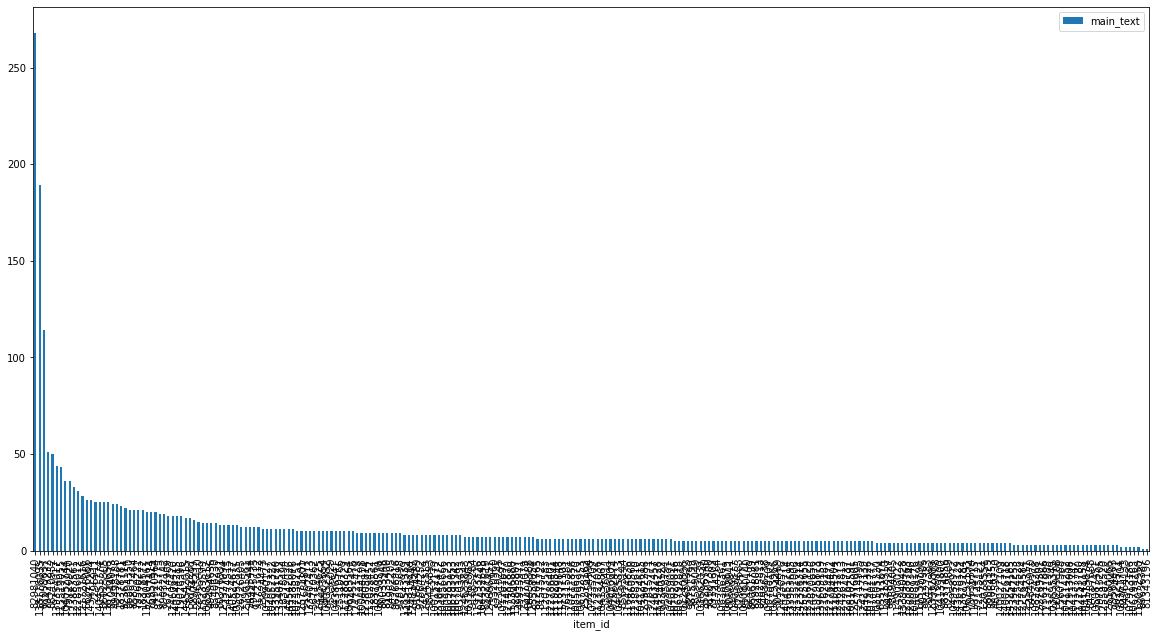

In [17]:
# Visualization
df2 = df.groupby('item_id').count().reset_index()[['item_id', 'main_text']]
df2 = df2.sort_values('main_text', ascending=False)
df2 = df2[df2['main_text']<500]

df2.plot(kind='bar', x='item_id', figsize=(20,10))
plt.xticks(rotation='vertical')
plt.show()

We can see that its long-tail highly class imbalanced problem.

In [18]:
# converting y-label(item_id) to 0-260 using labelencoder
le.fit(df['item_id'])
df['item_id'] = le.transform(df['item_id'])

# making train test split
# train split = 80%
# test split = 20%
train, test = train_test_split(df, test_size=0.2, random_state=12)

print(len(train)) #2294
print(len(test)) #574

2294
574


In [19]:
# preprocessing/cleaning of data

word2vec_processed_array = []
vocabulary = []

def strip_accents(text):
  """
    Strip accents from input String.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
  text = unicodedata.normalize('NFD', text)
  text = text.encode('ascii', 'ignore')
  text = text.decode("utf-8")
  return str(text)


def preprocess(text, is_train):
  """
    Instead of tokenizing directly removing all punctuations, here
    we handle numerical data first, and remove all other special characters.
    
    Replace all numberical data seperator from (',' or '-' or ',') to '_'
    Example:
    02.25 = 02_25
    02,25 = 02_25
    02-25 = 02_25
    2.2 = 2_2
    
    Note: must contain number both side of the special_character
    This step is done to maintain the relationship that numerical data may have

    Then we replace all special characters and punctuations except '_' with ' '
    
    Note: we also build the vocabulary of sentences found only in training data
    (is_train) = True, so that we can train custom word2vec model for embeddings
    
    :param text: The input string.
    :type text: String.

    :param is_train: build vocabulary is is_train = True
    :type text: Boolean.

    :returns: The processed String.
    :rtype: String.
    """
    
  processed_text = re.sub('([0-9]+)[,|.|-]([0-9]+)', '\\1_\\2', text)
  processed_text = re.sub('\W+',' ', processed_text)
  processed_text = processed_text.strip()

  processed_text = strip_accents(processed_text)
  # sent = ' '.join(word for word in processed_text.split() if len(word)>1)

  if is_train: # as embedding model will be trained only with training data
    processed_words = processed_text.split()
    word2vec_processed_array.append(processed_words)
    vocabulary.extend(processed_words)
  
  return processed_text


In [20]:
def preprocess_main(data, is_train=False):
  """
    Main function to preprocess both train and test data
    We combine 'main_text' and 'retailer_pg' and 'country_name' 
    and store it to 'feature_text' column in the dataframe.
    And pass them to preprocess method to clean the text
    'main_text','retailer_pg','country_name' is then dropped from the dataframe

    :param data: Dataframe of train or test split
    :type data: Dataframe.
    :param is_train: build vocabulary is is_train = True
    :type text: Boolean.

    :returns: Dataframe 
    :rtype: String.
    """
  
  for index, row in data.iterrows():
    text = row['main_text'] + ' ' + row['retailer_pg'] + ' ' + row['country_name']
    # get clean processed text from preprocess method
    clean_text = preprocess(text, is_train)
    # assign clean text to new column feature_text
    data.loc[index, 'feature_text'] = clean_text

  data = data.drop(columns=['main_text', 'retailer_pg', 'country_name'], axis=1)
  return data


In [21]:
# pass train and test splits(dataframe) to preprocess method
train = preprocess_main(train, is_train=True)
test = preprocess_main(test)

# seperate train label Y train
y_train = train.pop('item_id')
y_train = y_train.values.ravel() # to conver to 1-D numpy
print(y_train.shape)

# seperate test label Y test:
y_test = test.pop('item_id')
y_test = y_test.values.ravel() # to conver to 1-D numpy
print(y_test.shape)

(2294,)
(574,)


# Training Custom Word2Vec

In [22]:
# Train custom word2Vec model from Gensim
# Sentences are processed sentences('main_text' + 'retailer_pg')
# sentences only involve training data.

if APPLY_WORD2VEC_EMBEDDINGS:
  start_time = time.time()

  word2vec_model = Word2Vec(sentences=word2vec_processed_array,
                  sg=1, # 1 for skip_gram, 0 for CBOW
                  min_count=1,
                  size=WORD2VEC_EMBEDDING_DIMENSION,  
                  workers=4)

  print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')

  keys = set(word2vec_model.wv.vocab.keys())
  print('Total vocab of trained word2vec model:', len(keys))
  print('Dimension of trained word2vec vectors:',word2vec_model.wv.vector_size)
  # print(model.wv.get_vector('CRISTALES')) 

  # Save the word2vec model
  word2vec_model.wv.save_word2vec_format('custom_word2vec_model_100d.txt')
  word_vectors = word2vec_model

In [23]:
def apply_word2vec(data):
  """
  For each data row, take embedding vector for each token in the sentence
  from the trained word2vec model 
  and take mean of those vectors to for one vector for a sentence. 
  """

  D = WORD2VEC_EMBEDDING_DIMENSION
  X = np.zeros((len(data), D))
  n = 0
  emptycount = 0
  for rows in data:
    tokens = rows.split()
    vecs = []
    m = 0
    for word in tokens:
      try:
        # throws KeyError if word not found
        vec = word_vectors.wv.get_vector(word)
        vecs.append(vec)
        m += 1
      except KeyError:
        pass
    if len(vecs) > 0:
      vecs = np.array(vecs)
      X[n] = vecs.mean(axis=0)
    else:
      emptycount += 1
    n += 1
  print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
  return X


## BERT Embeddings:

In [24]:
if APPLY_BERT_EMBEDDINGS:
  !pip install -U sentence-transformers
  from sentence_transformers import SentenceTransformer

  bert_model = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')

def get_bert_embeddings(data):
  '''
  Apply bert embeddings to sentences provided in dataframe
  :param data: Series of sentences
  :type data: Dataframe Series

  :returns: list of embeddings of sentences 
  :shape: (num_of_sentences, bert_embd_dimension)
  :rtype: List of List.
  '''
  D = 768
  data = data.to_list()
  embeddings = bert_model.encode(data)
  return embeddings



     |████████████████████████████████| 79 kB 3.2 MB/s 
     |████████████████████████████████| 3.5 MB 10.8 MB/s 
     |████████████████████████████████| 1.2 MB 41.1 MB/s 
     |████████████████████████████████| 67 kB 4.3 MB/s 
     |████████████████████████████████| 895 kB 42.8 MB/s 
     |████████████████████████████████| 596 kB 42.0 MB/s 
     |████████████████████████████████| 6.8 MB 41.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=b30f33f9e75ede139ce516e297a2e41e4b8c5144061356383a6544898d971db9
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

 
For Bert embeddings:  
We directly ger embeddings of the complete sentence


In [25]:
# Generating embeddings of train/test using Bert

if APPLY_BERT_EMBEDDINGS:
  # Train:
  # Get the features(embedding vectors) for train data
  x_train = get_bert_embeddings(train['feature_text'])
  print(x_train.shape)

  # Test:
  # Get the features(embedding vectors) for test data
  x_test = get_bert_embeddings(test['feature_text'])
  print(x_test.shape)

(2294, 768)
(574, 768)


For word2vec embeddings:   
We can get the embeddings of complete sentence in feature_text by taking mean of all embedding vectors of its words.

In [26]:
# Generating embeddings of train/test using word2vec

if APPLY_WORD2VEC_EMBEDDINGS:
  # Train:
  # Get the features(embedding vectors) for train data
  x_train = apply_word2vec(train['feature_text'])
  print(x_train.shape)

  if CREATE_ONEHOT_COUNTRY:
    # Add features from one-hot encoding of country
    country_train = train[['country_GERMANY', 'country_SPAIN']].to_numpy()
    print(country_train.shape)

    x_train = np.concatenate((x_train, country_train), axis=1)
    print(x_train.shape)

  # Test:
  # Get the features(embedding vectors) for test data
  x_test = apply_word2vec(test['feature_text'])
  print(x_test.shape)

  if CREATE_ONEHOT_COUNTRY:
    # Add features from one-hot encoding of country
    country_test = test[['country_GERMANY', 'country_SPAIN']].to_numpy()
    print(country_test.shape)

    x_test = np.concatenate((x_test, country_test), axis=1)
    print(x_test.shape)

## Statistical Machine Learning Classifiers

In [29]:
import os
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

class ModelEvaluation:
    def __init__(self, predicted_output, actual_output):
        
        # Predictions from model & ground truth labels
        self.predicted_output = predicted_output
        self.actual_output = actual_output


    def classification_report(self, model_type: str, labels, target_names):
        print(f"\nOverall Classification Report for {model_type}: ")
        result = metrics.classification_report(self.actual_output,
                                                self.predicted_output,
                                                labels=labels, 
                                                target_names=target_names,
                                                output_dict=True)
        print(f"\n{pd.DataFrame.from_dict(result)}\n")

        return result

    
    def accuracy(self, model_type: str):
        acc = accuracy_score(self.actual_output, self.predicted_output)
        print(f'\n{model_type} Accuracy: {acc}')

        return acc

    
@staticmethod
def mean_accuracy(acc_list: list):
        # Example: rf_results = [0.8219, 0.9156]
         avg_acc = sum(acc_list)/len(acc_list)

         return avg_acc


class ClassifierModels:
    def __init__(self):

        # # DT:
        # self.dt_max_depth = 100

        # # RF:
        # self.rf_n_estimators = 100 # number of trees in the forest 200
        # self.rf_max_depth = 2

        # # SVC:
        # self.svc_c = 1.0
        # self.svc_kernel = 'poly' # 'rbf', 'linear'
        # self.svc_max_iter = -1 # 20

        # # ADA Boost:
        # self.ada_dt_max_depth = 1 # 100
        # self.ada_num_estimators = 50 # 100

        # # XG-Boost:
        # self.xgb_max_depth = 3 # 25
        # self.xgb_n_estimators = 200 # 100
        # self.xgb_learning_rate = 0.1 # 0.2
        # self.xgb_objective = "multi:softprob" # 'multi:softmax'

        #Instantiate a decision tree classifier object
        self.decision_model = DecisionTreeClassifier(max_depth=100, 
                                                    min_impurity_decrease=0.4, 
                                                    random_state=50)
        
        #Instantiate a random forest classifier object
        self.random_forest_classifier = RandomForestClassifier(n_estimators=200, 
                                                                random_state=50,
                                                                max_depth=2,
                                                                n_jobs=100,
                                                                verbose=0)
        
        #Instantiate a svm classifier object
        self.support_vector_classifier = SVC(C=0.8, random_state=50, 
                                            shrinking=True, kernel='poly', max_iter=20,
                                            cache_size=40000)
        
        #Instantiate a ADABoost classifier object
        dtree_obj = DecisionTreeClassifier(max_depth=20)
        self.ada_boost_classifier = AdaBoostClassifier(dtree_obj, 
                                                        n_estimators=100,
                                                        random_state=50)
        
        #Instantiate a XGBoost classifier object
        self.xgboost = XGBClassifier(max_depth=25, gpu_id=3, use_label_encoder=True, 
                                    verbosity=0, objective='multi:softmax', 
                                    learning_rate=0.2, n_estimators=200, 
                                    seed=50)

        

    

    # Decision Tree Classifier
    def decision_tree(self, train_dataset: list, train_labels: list, 
                        test_dataset: list, test_labels: list, optional:str=None):
        
        print("\nTraining a Decision Tree Model. Please wait...")

        self.decision_model = self.decision_model.fit(train_dataset, train_labels)
        #print( self.decision_model)

        # Predict
        pred = self.decision_model.predict(test_dataset)

        # Object of evaluation class
        eval = ModelEvaluation(pred, test_labels)
        model_type = "Decision Tree"
        
        accuracy = eval.accuracy(model_type)
        classification_report = eval.classification_report(model_type, labels=df['item_id'].unique(), target_names=df['item_id'].unique())

        return accuracy, classification_report
    
    
    # Random Forest Classifier
    def random_forest(self, train_dataset: list, train_labels: list, 
                        test_dataset: list, test_labels: list, optional:str=None):
        
        print("\nTraining a Random Forest Model. Please wait...")

        if HYPERPARAMETER_SEARCH:
          # Parameters for Hyperparameters search
      
          # Number of trees in random forest
          n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
          # Maximum number of levels in tree
          max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
          max_depth.append(None)
          # Minimum number of samples required to split a node
          min_samples_split = [2, 4, 5, 10]
          # Method of selecting samples for training each tree
          bootstrap = [True, False]
        
        else:
          n_estimators = [200]
          max_depth = [50]
          min_samples_split = [2]
          bootstrap = [True]

        # Create the random grid
        param_grid = {'n_estimators': n_estimators,
                      'max_depth': max_depth,
                      'min_samples_split': min_samples_split,
                      'bootstrap': bootstrap}
        
        print(param_grid)

        rf_Grid = GridSearchCV(estimator = self.random_forest_classifier, 
                              param_grid = param_grid, cv = CROSS_VALIDATION_FOLD, 
                              verbose=2, n_jobs = 4)
        rf_Grid.fit(train_dataset, train_labels)
        print(rf_Grid.best_params_)
        print (f'Random Forest Train Accuracy - : {rf_Grid.score(train_dataset,train_labels):.3f}')
        print (f'Random Forest Test Accuracy - : {rf_Grid.score(test_dataset,test_labels):.3f}')


        pred = rf_Grid.predict(test_dataset)

        # Object of evaluation class
        eval = ModelEvaluation(pred, test_labels)
        model_type = "Random Forest"
        
        accuracy = eval.accuracy(model_type)
        classification_report = eval.classification_report(model_type, labels=df['item_id'].unique(), target_names=df['item_id'].unique())
    
        return accuracy, classification_report

    
    # SVM Classifier
    def svm_classifier(self, train_dataset: list, train_labels: list, test_dataset: list, 
                        test_labels: list,  optional:str=None):
        
        print("\nTraining a SVM Model. Please wait...")

        self.support_vector_classifier =  self.support_vector_classifier.fit(train_dataset, 
                                                                            train_labels)
        #print(self.svm_classifier)

        #Predict the response for test dataset
        pred = self.support_vector_classifier.predict(test_dataset)

        # Object of evaluation class
        eval = ModelEvaluation(pred, test_labels)
        model_type = "Support Vector Classifier"
        
        accuracy = eval.accuracy(model_type)
        classification_report = eval.classification_report(model_type, labels=df['item_id'].unique(), target_names=df['item_id'].unique())

        return accuracy, classification_report
    

    # XGBoost Classifier
    def xg_boost(self, train_dataset: list, train_labels: list, test_dataset: list, 
                    test_labels: list, optional:str=None):
        
        print("\nTraining a XGBoost Model. Please wait...")
        if HYPERPARAMETER_SEARCH:
          param_grid = {
              'max_depth': [3, 5, 10, 20, 25, 50],
              'n_estimators': [100,200],
              'learning_rate': [0.1, 0.2, 0.3],
              'objective': ["multi:softprob", "multi:softmax"]
          }
        
        else:
          param_grid = {
              'max_depth': [25],
              'n_estimators': [200],
              'learning_rate': [0.1],
              'objective': ["multi:softmax"]
          }

        xgb_grid = GridSearchCV(self.xgboost, param_grid=param_grid, 
                                cv = CROSS_VALIDATION_FOLD, verbose=2, n_jobs = 4)
        

        xgb_grid.fit(train_dataset, train_labels)
        print(xgb_grid.best_params_)
        print (f'XG Boost Train Accuracy - : {xgb_grid.score(train_dataset,train_labels):.3f}')
        print (f'XG Boost Test Accuracy - : {xgb_grid.score(test_dataset,test_labels):.3f}')

        # predict labels
        pred = xgb_grid.predict(test_dataset)

        # Object of evaluation class
        eval = ModelEvaluation(pred, test_labels)
        model_type = "Xtreme Gradient Boosting Classifier"
        
        accuracy = eval.accuracy(model_type)
        classification_report = eval.classification_report(model_type, labels=df['item_id'].unique(), target_names=df['item_id'].unique())

        return accuracy, classification_report

    # ADABoost Classifier
    def ada_boost(self, train_dataset: list, train_labels: list, test_dataset: list, 
                    test_labels: list, optional:str=None):
        
        print("\nTraining a ADABoost Model. Please wait...")
        
        if HYPERPARAMETER_SEARCH:
          param_grid = {
              'base_estimator__max_depth':[i for i in range(2,11,2)],
              'n_estimators': [100,200],
              'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]
          }
        
        else:
          param_grid = {
              'base_estimator__max_depth': [20],
              'n_estimators': [100],
              'learning_rate': [0.1]
          }

        ada_grid = GridSearchCV(self.ada_boost_classifier, param_grid=param_grid, 
                                cv = CROSS_VALIDATION_FOLD, verbose=2, n_jobs = 4)
        

        ada_grid.fit(train_dataset, train_labels)
        print(ada_grid.best_params_)
        print (f'ADA Boost Train Accuracy - : {ada_grid.score(train_dataset,train_labels):.3f}')
        print (f'ADA Boost Test Accuracy - : {ada_grid.score(test_dataset,test_labels):.3f}')

        # predict labels
        pred = ada_grid.predict(test_dataset)
        # pred = self.ada_boost_classifier.predict(test_dataset)

        # Object of evaluation class
        eval = ModelEvaluation(pred, test_labels)
        model_type = "ADABoost Classifier"
        
        accuracy = eval.accuracy(model_type)
        classification_report = eval.classification_report(model_type, labels=df['item_id'].unique(), target_names=df['item_id'].unique())

        return accuracy, classification_report


def train_eval_rf():
    ml_models = ClassifierModels()

    acc, cla_report = ml_models.random_forest(x_train, y_train, x_test, y_test)
        
    print("\nOverall Accuracy Score:", acc)
    print("\nOverall Classification Report:\n", cla_report)


def train_eval_dt():
    
    ml_models = ClassifierModels()
    
    acc, cla_report = ml_models.decision_tree(x_train, y_train, x_test, y_test)

    print("\nOverall Accyracy Score:", acc)
    print("\nOverall Classification Report:\n", cla_report)


def train_eval_svm():

    ml_models = ClassifierModels()

    acc, cla_report = ml_models.svm_classifier(x_train, y_train, x_test, y_test)
        
    print("\nOverall Accyracy Score:", acc)
    print("\nOverall Classification Report:\n", cla_report)


def train_eval_xg_boost():
    
    ml_models = ClassifierModels()

    acc, cla_report = ml_models.xg_boost(x_train, y_train, x_test, y_test)
    print("\nOverall Accyracy Score:", acc)
    print("\nOverall Classification Report:\n", cla_report)

def train_eval_ada_boost():
    
    ml_models = ClassifierModels()

    acc, cla_report = ml_models.ada_boost(x_train, y_train, x_test, y_test)
        
    print("\nOverall Accyracy Score:", acc)
    print("\nOverall Classification Report:\n", cla_report)

    
if __name__ == "__main__":
    # pass
    train_eval_dt()
    train_eval_svm()
    train_eval_rf()
    train_eval_ada_boost()
    train_eval_xg_boost()



Training a Decision Tree Model. Please wait...

Decision Tree Accuracy: 0.09930313588850175

Overall Classification Report for Decision Tree: 

            137    6  146   232  ...  134   micro avg   macro avg  weighted avg
precision   0.0  0.0  0.0   0.0  ...  0.0    0.099303    0.000382      0.009861
recall      0.0  0.0  0.0   0.0  ...  0.0    0.099303    0.003846      0.099303
f1-score    0.0  0.0  0.0   0.0  ...  0.0    0.099303    0.000695      0.017941
support    43.0  0.0  4.0  12.0  ...  2.0  574.000000  574.000000    574.000000

[4 rows x 263 columns]


Overall Accyracy Score: 0.09930313588850175

Overall Classification Report:
 {137: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 43}, 6: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 146: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4}, 232: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12}, 74: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1


Support Vector Classifier Accuracy: 0.573170731707317

Overall Classification Report for Support Vector Classifier: 

                 137    6   146  ...   micro avg   macro avg  weighted avg
precision   0.840000  0.0  1.00  ...    0.573171    0.224786      0.511567
recall      0.976744  0.0  0.25  ...    0.573171    0.249995      0.573171
f1-score    0.903226  0.0  0.40  ...    0.573171    0.217419      0.508402
support    43.000000  0.0  4.00  ...  574.000000  574.000000    574.000000

[4 rows x 263 columns]


Overall Accyracy Score: 0.573170731707317

Overall Classification Report:
 {137: {'precision': 0.84, 'recall': 0.9767441860465116, 'f1-score': 0.9032258064516129, 'support': 43}, 6: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 146: {'precision': 1.0, 'recall': 0.25, 'f1-score': 0.4, 'support': 4}, 232: {'precision': 0.2972972972972973, 'recall': 0.9166666666666666, 'f1-score': 0.4489795918367347, 'support': 12}, 74: {'precision': 1.0, 'recall': 0.66666666

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

{'bootstrap': True, 'max_depth': 50, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Train Accuracy - : 0.993
Random Forest Test Accuracy - : 0.754

Random Forest Accuracy: 0.7543554006968641

Overall Classification Report for Random Forest: 

                 137    6       146  ...   micro avg   macro avg  weighted avg
precision   0.914894  0.0  1.000000  ...    0.754355    0.475781      0.736725
recall      1.000000  0.0  0.500000  ...    0.754355    0.485830      0.754355
f1-score    0.955556  0.0  0.666667  ...    0.754355    0.462449      0.722778
support    43.000000  0.0  4.000000  ...  574.000000  574.000000    574.000000

[4 rows x 263 columns]



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1


Overall Accuracy Score: 0.7543554006968641

Overall Classification Report:
 {137: {'precision': 0.9148936170212766, 'recall': 1.0, 'f1-score': 0.9555555555555556, 'support': 43}, 6: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 146: {'precision': 1.0, 'recall': 0.5, 'f1-score': 0.6666666666666666, 'support': 4}, 232: {'precision': 0.5, 'recall': 0.6666666666666666, 'f1-score': 0.5714285714285715, 'support': 12}, 74: {'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8, 'support': 3}, 228: {'precision': 1.0, 'recall': 0.8333333333333334, 'f1-score': 0.9090909090909091, 'support': 6}, 139: {'precision': 0.8181818181818182, 'recall': 1.0, 'f1-score': 0.9, 'support': 9}, 88: {'precision': 0.75, 'recall': 0.8571428571428571, 'f1-score': 0.7999999999999999, 'support': 7}, 163: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1}, 156: {'precision': 1.0, 'recall': 0.4, 'f1-score': 0.5714285714285715, 'support': 5}, 96: {'precision': 0.4, 'recall': 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,


{'base_estimator__max_depth': 20, 'learning_rate': 0.1, 'n_estimators': 100}
ADA Boost Train Accuracy - : 0.993
ADA Boost Test Accuracy - : 0.592

ADABoost Classifier Accuracy: 0.5923344947735192

Overall Classification Report for ADABoost Classifier: 

                 137    6       146  ...   micro avg   macro avg  weighted avg
precision   0.792453  0.0  1.000000  ...    0.592334    0.378442      0.602019
recall      0.976744  0.0  0.500000  ...    0.592334    0.341400      0.592334
f1-score    0.875000  0.0  0.666667  ...    0.592334    0.342546      0.554477
support    43.000000  0.0  4.000000  ...  574.000000  574.000000    574.000000

[4 rows x 263 columns]


Overall Accyracy Score: 0.5923344947735192

Overall Classification Report:
 {137: {'precision': 0.7924528301886793, 'recall': 0.9767441860465116, 'f1-score': 0.875, 'support': 43}, 6: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 146: {'precision': 1.0, 'recall': 0.5, 'f1-score': 0.6666666666666666, 'sup

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

{'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 200, 'objective': 'multi:softmax'}
XG Boost Train Accuracy - : 0.993
XG Boost Test Accuracy - : 0.760

Xtreme Gradient Boosting Classifier Accuracy: 0.759581881533101

Overall Classification Report for Xtreme Gradient Boosting Classifier: 

                 137    6       146  ...   micro avg   macro avg  weighted avg
precision   0.954545  0.0  0.666667  ...    0.759582    0.475126      0.767270
recall      0.976744  0.0  0.500000  ...    0.759582    0.489064      0.759582
f1-score    0.965517  0.0  0.571429  ...    0.759582    0.462866      0.744971
support    43.000000  0.0  4.000000  ...  574.000000  574.000000    574.000000

[4 rows x 263 columns]


Overall Accyracy Score: 0.759581881533101

Overall Classification Report:
 {137: {'precision': 0.9545454545454546, 'recall': 0.9767441860465116, 'f1-score': 0.9655172413793104, 'support': 43}, 6: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 146: {'precision': 0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1